## Download data

In [1]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load data

In [2]:
import pandas as pd

df = pd.read_parquet("../../../data/EIA/fuel_type_data_california.parquet")
df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-04-22 20:00:00-07:00,CAL,California,BAT,Battery storage,179,megawatthours
1,2025-04-22 20:00:00-07:00,CAL,California,COL,Coal,216,megawatthours
...,...,...,...,...,...,...,...
452546,2018-12-31 17:00:00-07:00,CAL,California,WAT,Hydro,2880,megawatthours
452547,2018-12-31 17:00:00-07:00,CAL,California,WND,Wind,2628,megawatthours


## Preprocess data

### Filter time series

To get a table with the unique datetime index of the series, and the time series values.

In [3]:
df[['fueltype', 'type-name']].drop_duplicates().style

,fueltype,type-name
0,BAT,Battery storage
1,COL,Coal
2,GEO,Geothermal
3,NG,Natural Gas
4,NUC,Nuclear
5,OIL,Petroleum
6,OTH,Other
7,PS,Pumped storage
8,SNB,Solar with integrated battery storage
9,SUN,Solar


In [4]:
FUELTYPE = 'SUN'

In [5]:
df = df.query('fueltype == @FUELTYPE').copy()
df

,period,respondent,respondent-name,fueltype,type-name,value,value-units
9,2025-04-22 20:00:00-07:00,CAL,California,SUN,Solar,5113,megawatthours
21,2025-04-22 19:00:00-07:00,CAL,California,SUN,Solar,13293,megawatthours
...,...,...,...,...,...,...,...
452537,2018-12-31 18:00:00-07:00,CAL,California,SUN,Solar,8,megawatthours
452545,2018-12-31 17:00:00-07:00,CAL,California,SUN,Solar,1595,megawatthours


### Set datetime index

The index must be a datetime object and unique, while the values must be a numeric object.

In [6]:
df['period'] = pd.to_datetime(df['period'])
df['period']

9        2025-04-22 20:00:00-07:00
21       2025-04-22 19:00:00-07:00
                    ...           
452537   2018-12-31 18:00:00-07:00
452545   2018-12-31 17:00:00-07:00
Name: period, Length: 55300, dtype: datetime64[us, pytz.FixedOffset(-420)]

In [7]:
df = df.set_index('period').sort_index()
df

,respondent,respondent-name,fueltype,type-name,value,value-units
period,,,,,,
2018-12-31 17:00:00-07:00,CAL,California,SUN,Solar,1595,megawatthours
2018-12-31 18:00:00-07:00,CAL,California,SUN,Solar,8,megawatthours
...,...,...,...,...,...,...
2025-04-22 19:00:00-07:00,CAL,California,SUN,Solar,13293,megawatthours
2025-04-22 20:00:00-07:00,CAL,California,SUN,Solar,5113,megawatthours


In [8]:
df = df.tz_localize(None) # required for some models

In [9]:
df.index.is_unique

True

In [10]:
df = df[['value']]
df.columns = ['values']
df

,values
period,
2018-12-31 17:00:00,1595
2018-12-31 18:00:00,8
...,...
2025-04-22 19:00:00,13293
2025-04-22 20:00:00,5113


In [11]:
df.plot()

### Filter datetime index

In [12]:
df = df.loc['2019':'2024']
df

,values
period,
2019-01-01 00:00:00,-22
2019-01-01 01:00:00,-22
...,...
2024-12-31 22:00:00,64
2024-12-31 23:00:00,59


### Aggregate

In [13]:
x = df.resample('ME').sum()
x.plot()

In [14]:
df = x.copy()
df

,values
period,
2019-01-31,1533631
2019-02-28,1681819
...,...
2024-11-30,2952150
2024-12-31,2669105


## Data stationarity

### Data transformation

#### Constant variance

In [16]:
from statsmodels.tsa.stattools import adfuller
adfuller(df["values"])

(np.float64(1.060262159024415),
 np.float64(0.9948627912023307),
 10,
 61,
 {'1%': np.float64(-3.542412746661615),
  '5%': np.float64(-2.910236235808284),
  '10%': np.float64(-2.5927445767266866)},
 np.float64(1643.3057751789806))

In [17]:
import numpy as np

df["values_log"] = np.log(df["values"])
df = df.dropna()
df

,values,values_log
period,,
2019-01-31,1533631,14.243149
2019-02-28,1681819,14.335387
...,...,...
2024-11-30,2952150,14.898044
2024-12-31,2669105,14.797254


In [18]:
adfuller(df["values_log"])

(np.float64(0.14752725911536463),
 np.float64(0.969160144990337),
 11,
 60,
 {'1%': np.float64(-3.5443688564814813),
  '5%': np.float64(-2.9110731481481484),
  '10%': np.float64(-2.5931902777777776)},
 np.float64(-106.3172732985166))

In [19]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [20]:
utils.plot_decomposition_comparison(df["values_log"], period=24)

#### Constant mean

In [21]:
df['values_log_diff'] = df['values_log'].diff().dropna()
df

,values,values_log,values_log_diff
period,,,
2019-01-31,1533631,14.243149,NaN
2019-02-28,1681819,14.335387,0.092238
...,...,...,...
2024-11-30,2952150,14.898044,-0.338555
2024-12-31,2669105,14.797254,-0.100791


In [22]:
df = df.dropna()
df

,values,values_log,values_log_diff
period,,,
2019-02-28,1681819,14.335387,0.092238
2019-03-31,2463585,14.717128,0.381742
...,...,...,...
2024-11-30,2952150,14.898044,-0.338555
2024-12-31,2669105,14.797254,-0.100791


In [23]:
fig = df.plot(facet_col="variable")
fig.update_yaxes(matches=None)
fig.update_layout()

In [24]:
adfuller(df["values_log_diff"])

(np.float64(-7.802308358760293),
 np.float64(7.437095401308938e-12),
 10,
 60,
 {'1%': np.float64(-3.5443688564814813),
  '5%': np.float64(-2.9110731481481484),
  '10%': np.float64(-2.5931902777777776)},
 np.float64(-105.20440579244911))

## ACF & PACF


In [25]:
column = "values"

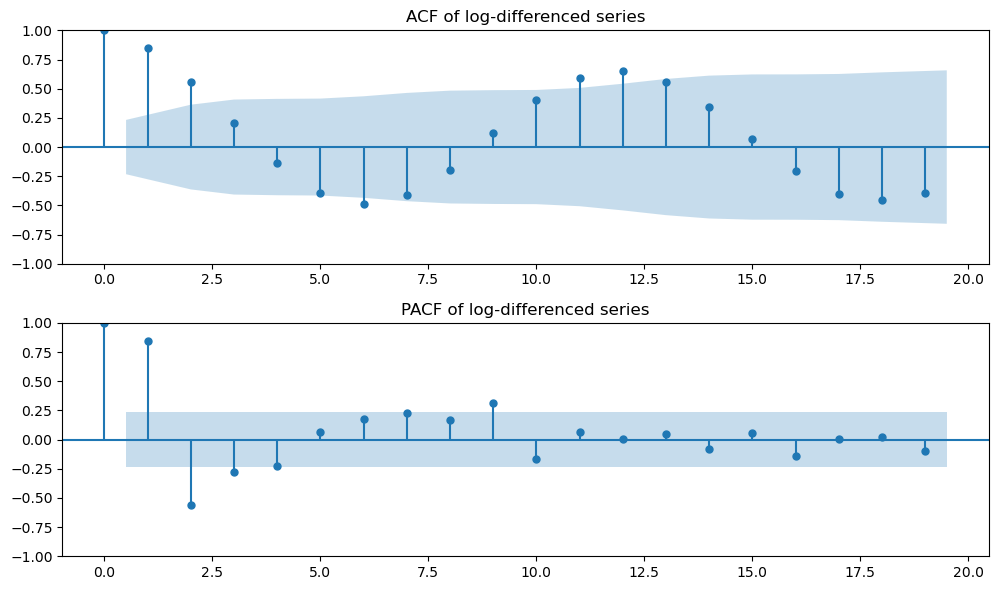

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(df[column], ax=axes[0])
axes[0].set_title("ACF of log-differenced series")

plot_pacf(df[column], ax=axes[1])
axes[1].set_title("PACF of log-differenced series")

plt.tight_layout()
plt.show()

## Train test split

In [27]:
df = df[["values", "values_log"]]
df

,values,values_log
period,,
2019-02-28,1681819,14.335387
2019-03-31,2463585,14.717128
...,...,...
2024-11-30,2952150,14.898044
2024-12-31,2669105,14.797254


In [28]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df['values'], test_size=0.3, shuffle=False)

## Variation playground

### Experiment configuration

In [29]:
from modules.utils import TimeSeriesForecaster

In [30]:
configs = {
    'sarima': {
        'model_params': {
            'order': (0, 1, 1),
            'seasonal_order': (0, 1, 1, 12),
            'enforce_invertibility': False,
            'enforce_stationarity': False,
        },
        'log_transform': True,
    },
    'ets': {
        'model_params': {
            'trend': 'add',
            'seasonal': 'mul',
            'damped_trend': False,
        },
        'log_transform': False,
    },
    'prophet': {
        'model_params': {
            'seasonality_mode': 'multiplicative',
            'yearly_seasonality': True,
        },
        'log_transform': True,
    },
}

In [31]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'rmse': root_mean_squared_error,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
}

### Run experiment with all models

In [32]:
from modules.utils import TimeSeriesForecaster

tf = TimeSeriesForecaster(train=train, test=test, freq="ME")
df_forecast = tf.bulk_forecast(configs, metrics=metrics)
df_forecast

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

18:37:09 - cmdstanpy - INFO - Chain [1] start processing
18:37:09 - cmdstanpy - INFO - Chain [1] done processing


,model,split,values,datetime,rmse,mae,mape
0,sarima,train,"[3211094.0861719754, 2718386.1637942065, 28701...","DatetimeIndex(['2020-03-31', '2020-04-30', '20...",3.401435e+05,2.548626e+05,9.265601e-02
1,sarima,test,"[3515830.5722457026, 4101036.813829004, 472740...","DatetimeIndex(['2023-03-31', '2023-04-30', '20...",3.758159e+05,3.031194e+05,8.168841e-02
...,...,...,...,...,...,...,...
4,prophet,train,"[487.086876001817, 22.48792626067512, 8443.670...","DatetimeIndex(['2020-03-31', '2020-04-30', '20...",2.988196e+16,6.081528e+15,3.373712e+09
5,prophet,test,"[85.50881064165914, 31.354674102789527, 53018....","DatetimeIndex(['2023-03-31', '2023-04-30', '20...",1.949485e+17,5.068165e+16,2.119673e+10


## Choose best model

### Forecast plot

In [33]:
df_combined = tf.combine_with_historical(df_forecast)
df_combined

,model,split,datetime,values
0,ets,test,2023-03-31,3057285.446971
1,ets,test,2023-04-30,3605844.875805
...,...,...,...,...
230,historical,test,2024-11-30,2952150
231,historical,test,2024-12-31,2669105


In [34]:
import plotly.express as px

fig = px.line(
    data_frame=df_combined,
    x='datetime',
    y='values',
    color='model',
    facet_col='split',
    category_orders={'split': ['train', 'test']}
)

fig.update_xaxes(matches=None)

### Metrics review

In [35]:
dfm = df_forecast.melt(id_vars=["split", "model"], value_vars=["rmse", "mae", "mape"])
dfp = dfm.pivot(index=["split", "model"], columns="variable", values="value")
dfp.style.background_gradient(cmap="Greens_r", axis=0).format(precision=2)

## Diagnostics to validate assumptions

### Model fit

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = order = (0, 1, 1)
P, D, Q, s = seasonal_order = (0, 1, 1, 12)

model = SARIMAX(df["values_log"], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

### Residuals

In [41]:
idx_offset = d + D * s

residuals = model_fit.resid[idx_offset:]
residuals

period
2020-03-31   -0.330229
2020-04-30   -0.129048
                ...   
2024-11-30   -0.087364
2024-12-31    0.134335
Freq: ME, Length: 58, dtype: float64

### Assumptions
#### Autocorrelation

##### Plot

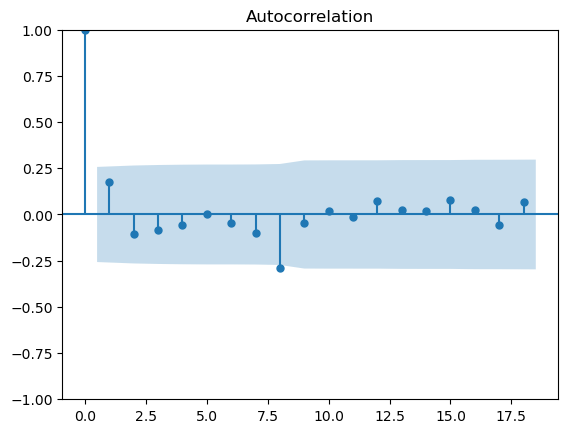

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals);

##### Test

In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(residuals, lags=[10, 20, 30]).style

,lb_stat,lb_pvalue
10,9.930108,0.446646
20,12.156315,0.910591
30,21.133107,0.883680


#### Normality

##### Plot

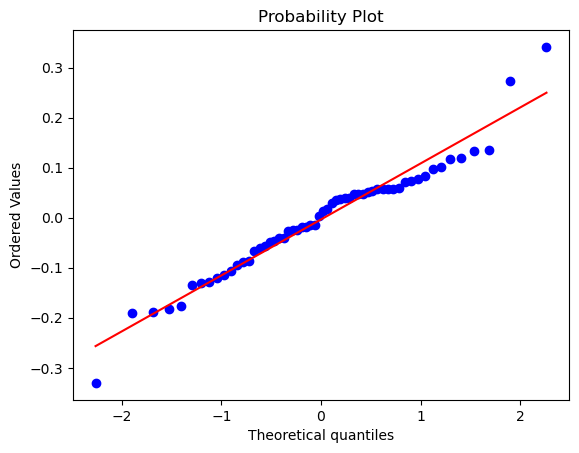

In [44]:
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots()
stats.probplot(residuals, dist='norm', plot=ax);

##### Test

In [45]:
from scipy.stats import jarque_bera
jarque_bera(residuals)

SignificanceResult(statistic=np.float64(4.754491302213924), pvalue=np.float64(0.09280584547820007))

#### Homoscedasticity

##### Plot

In [46]:
residuals.plot()

##### Test

In [47]:
from statsmodels.stats.diagnostic import het_arch
het_arch(residuals)

(np.float64(11.473666113893277),
 np.float64(0.32182401566103563),
 1.1622454296611606,
 0.34608190037202663)